In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt


In [3]:
data_dir = '/Users/sw376/Dropbox/Research/data/simulations/flares/colours'
hf = h5py.File(f'{data_dir}/DustModelI_7.0.h5')

z = hf['z'][:]

selection = (np.fabs(z-7.3)<0.1)&(hf['Webb.NIRCAM.F200W'][:]>5E28)

print(sum(selection))





2553


[ 45.2  75.7 108.3 186.  469.6 522.5 527.6 673.7]
[ 7.9  6.7  5.6  9.3 23.5 26.1 26.4 94.8]


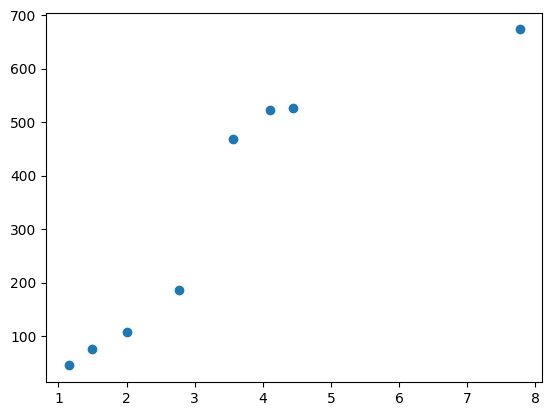

In [11]:


filters = [
    # 'Webb.NIRCAM.F090W',
    'Webb.NIRCAM.F115W',
    'Webb.NIRCAM.F150W',
    'Webb.NIRCAM.F200W',
    'Webb.NIRCAM.F277W',
    'Webb.NIRCAM.F356W',
    'Webb.NIRCAM.F410M',
    'Webb.NIRCAM.F444W',
    'Webb.MIRI.F770W',
]

filter_wavelengths_dict = {
    'Webb.NIRCAM.F090W': 0.9,
    'Webb.NIRCAM.F115W': 1.15,
    'Webb.NIRCAM.F150W': 1.5,
    'Webb.NIRCAM.F200W': 2.0,
    'Webb.NIRCAM.F277W': 2.77,
    'Webb.NIRCAM.F356W': 3.56,
    'Webb.NIRCAM.F410M': 4.10,
    'Webb.NIRCAM.F444W': 4.44,
    'Webb.MIRI.F770W': 7.77,
}

filter_wavelengths = np.array([filter_wavelengths_dict[filter] for filter in filters])


observed_fluxes = {
    'Webb.NIRCAM.F090W': -3.7,
    'Webb.NIRCAM.F115W': 45.2,
    'Webb.NIRCAM.F150W': 75.7,
    'Webb.NIRCAM.F200W': 108.3,
    'Webb.NIRCAM.F277W': 186.0,
    'Webb.NIRCAM.F356W': 469.6,
    'Webb.NIRCAM.F410M': 522.5,
    'Webb.NIRCAM.F444W': 527.6,
    'Webb.MIRI.F770W': 673.7,
}

observed_flux_errors = {
    'Webb.NIRCAM.F090W': 7.7,
    'Webb.NIRCAM.F115W': 7.9,
    'Webb.NIRCAM.F150W': 6.7,
    'Webb.NIRCAM.F200W': 5.6,
    'Webb.NIRCAM.F277W': 9.3,
    'Webb.NIRCAM.F356W': 23.5,
    'Webb.NIRCAM.F410M': 26.1,
    'Webb.NIRCAM.F444W': 26.4,
    'Webb.MIRI.F770W': 94.8,
}

# create arrays
observed_fluxes_array = np.array([observed_fluxes[filter] for filter in filters])
observed_flux_errors_array = np.array([observed_flux_errors[filter] for filter in filters])

print(observed_fluxes_array)
print(observed_flux_errors_array)

plt.scatter(filter_wavelengths, observed_fluxes_array)
plt.show()


In [5]:
#create arrays for the models


flares_luminosities = np.array([hf[filter][selection] for filter in filters]).T 

print(flares_luminosities.shape)

# convert from erg/s/Hz to nJy

(2553, 8)


(2553,)
(2553, 8)
[108.71369023 109.79968    108.57890498 119.50462738 173.2139682
 313.90088043 231.42311298 206.70483301]


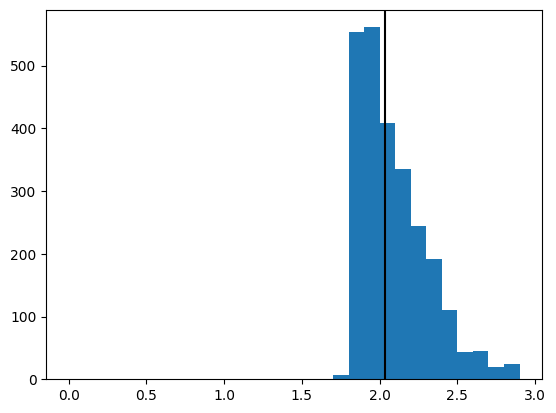

In [10]:
from unyt import erg, s, Hz, cm
from astropy.cosmology import Planck18 as cosmo


luminosity_distance = cosmo.luminosity_distance(z[selection]).to("cm").value * cm
conversion = (1 + z[selection]) / 4 / np.pi / luminosity_distance**2

print(conversion.shape)

# apply conversion
flares_fluxes = flares_luminosities * (erg / s / Hz) * np.expand_dims(conversion,1)

# convert to nJy and extract value
flares_fluxes = flares_fluxes.to('nJy').value

print(flares_fluxes.shape)

print(np.median(flares_fluxes, axis=0))

filter = 'Webb.NIRCAM.F200W'
plt.hist(np.log10(flares_fluxes[:, filters.index(filter)]), bins = np.arange(0., 3., 0.1))
plt.axvline(np.log10(observed_fluxes[filter]), c='k')
plt.show()


### Plot SEDs

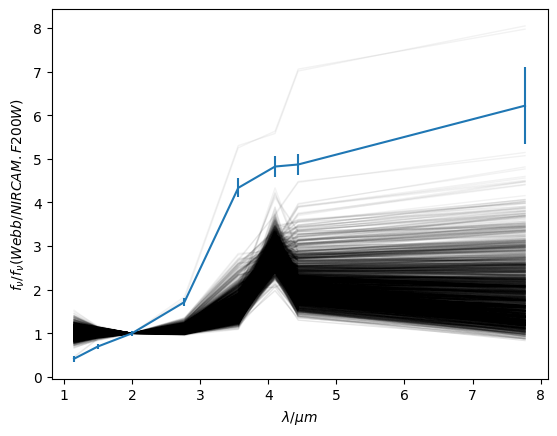

In [22]:

# normalise to F200W 
normalised_flares_fluxes = flares_fluxes / np.expand_dims(flares_fluxes[:, 2],1)

plt.plot(filter_wavelengths, normalised_flares_fluxes.T, c='k', alpha=0.05, lw=1)
plt.errorbar(filter_wavelengths, observed_fluxes_array / observed_fluxes_array[2], yerr = observed_flux_errors_array / observed_fluxes_array[2])
plt.xlabel(r'$\lambda/\mu m$')
plt.ylabel(r'$f_{\nu}/f_{\nu}(Webb/NIRCAM.F200W)$')
plt.show()



164.6940577571701
(2553,)


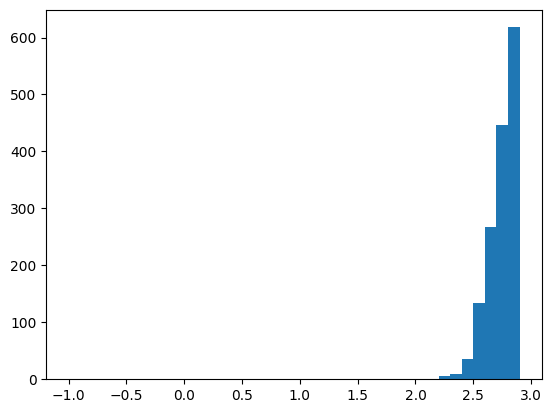

In [7]:





chi2 = np.sum((flares_fluxes - observed_fluxes_array)**2 / observed_flux_errors_array**2, axis=1)

print(np.min(chi2))
print(chi2.shape)


plt.hist(np.log10(chi2), bins = np.arange(-1., 3., 0.1))
plt.show()
